In [489]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{torch.__version__} running on {device}")

2.4.0+cu121 running on cuda


# GP Run for Image Classification
Your problem needs to fulfill the following criteria.
1. It is an image classification problem.
2. You supply marked training images and marked validation images.

Within those, the run is flexible and adapts itself to your problem.
Now, please describe your images and problem by setting those global variables:

In [490]:
IMAGE_WIDTH = 28 # <-- number of width-pixels
IMAGE_HEIGHT = 28 # <-- number of height-pixels
COLOUR_CHANNEL_COUNT = 1 # <-- RGB images would have 3
CLASSIFICATION_CATEGORIES_COUNT = 10 # <-- the amount of possible categories of which each image shall be marked with one

### Prepare Example Data
To check the code, we prepare example data: Fashion MNIST.

In [491]:
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data (and not testing data)
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())
print(f"train_data.classes = {train_data.classes}")

train_data.classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [492]:
from torch.utils.data import DataLoader
MINI_BATCH_SIZE = 32 # constant for now

# Turn datasets into iterables (batches), shuffeling train data every epoch (test data not)
train_dl_f_mnist = DataLoader(train_data, batch_size=MINI_BATCH_SIZE, shuffle=True)
test_dl_f_mnist = DataLoader(test_data, batch_size=MINI_BATCH_SIZE, shuffle=False)

print(f"train_dl_f_mnist.batch_size = {train_dl_f_mnist.batch_size}") 
print(f"len(next(iter(train_dl_f_mnist))) = {len(next(iter(train_dl_f_mnist)))}") 
print(f"next(iter(train_dl_f_mnist))[0].shape = {next(iter(train_dl_f_mnist))[0].shape}") 
print(f"len(train_dl_f_mnist) = {len(train_dl_f_mnist)}, len(test_dl_f_mnist) = {len(test_dl_f_mnist)}")

train_dl_f_mnist.batch_size = 32
len(next(iter(train_dl_f_mnist))) = 2
next(iter(train_dl_f_mnist))[0].shape = torch.Size([32, 1, 28, 28])
len(train_dl_f_mnist) = 1875, len(test_dl_f_mnist) = 313


Image shape: torch.Size([1, 28, 28])


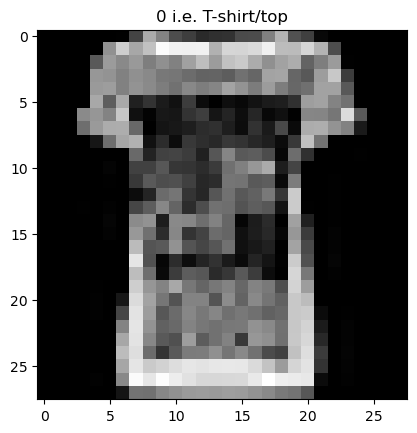

In [493]:
import matplotlib.pyplot as plt
image_index = 2 # index in the batch, 0 .. 31
train_features_batch, train_labels_batch = next(iter(train_dl_f_mnist))
print(f"Image shape: {train_features_batch[image_index].shape}")
plt.imshow(train_features_batch[image_index].squeeze(), cmap="gray") # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(str(train_labels_batch[image_index].item())+" i.e. "+train_data.classes[train_labels_batch[image_index].item()]);

## The Individuals' Class
- The Hyperparamters should be passed to the constructor in a way that is both convenient for GP and for PyTorch.
- I think I want to define a class for one `nn.Sequential` 2d-block
    - All possible instances should be concatenable with all possible instances
- Then, an individual is built from the concatenation of many such blocks, plus data preparation and final f.c. layer

In [494]:
''' 
define a λ nn.Module that creates an nn layer from a given function
this is handy for nn.Sequential usage '''
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x):
        return self.func(x)
    
'''
create a function to reshape the (28x28) image input data '''
def preprocess(x):
    return x.view(-1, 1, 28, 28)

In [495]:
class Sequential_block_2d(nn.Module):
    def __init__(self, 
                 out_channels: int, # the number of output neurons after the full block
                 in_channels: int = 1, # should not be set here, but is set in Individual's __init__()
                 conv_kernel_size: int = 3,
                 conv_stride: int = 1,
                 conv_padding: int = 1,
                 pool_kernel_size: int = 2,
                 pool_stride: int = 2,
                 pool_padding: int = 0):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=conv_kernel_size,
                      stride=conv_stride,
                      padding=conv_padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size,
                         stride=pool_stride,
                         padding=pool_padding)
        )
    def forward(self, x):
        return self.block(x)

# generate some testing blocks (TODO: write actual unit tests)
testBlock1 = Sequential_block_2d(in_channels=1,out_channels=5)
testBlock2 = Sequential_block_2d(in_channels=5,out_channels=3)
torch.manual_seed(42)
testX = torch.randn(COLOUR_CHANNEL_COUNT,IMAGE_WIDTH,IMAGE_HEIGHT)
testBlock1, testBlock2, testX, testBlock1(testX)
print(f"testX.shape = {testX.shape}\ntestX[:,:3]: {testX[:,:3]}")
print(f"testBlock1(testX).shape = {testBlock1(testX).shape}\ntestBlock1(testX)[:1,:3]: {testBlock1(testX)[:1,:3]}")

testX.shape = torch.Size([1, 28, 28])
testX[:,:3]: tensor([[[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784, -1.2345, -0.0431,
          -1.6047, -0.7521,  1.6487, -0.3925, -1.4036, -0.7279, -0.5594,
          -0.7688,  0.7624,  1.6423, -0.1596, -0.4974,  0.4396, -0.7581,
           1.0783,  0.8008,  1.6806,  1.2791,  1.2964,  0.6105,  1.3347],
         [-0.2316,  0.0418, -0.2516,  0.8599, -1.3847, -0.8712, -0.2234,
           1.7174,  0.3189, -0.4245,  0.3057, -0.7746, -1.5576,  0.9956,
          -0.8798, -0.6011, -1.2742,  2.1228, -1.2347, -0.4879, -0.9138,
          -0.6581,  0.0780,  0.5258, -0.4880,  1.1914, -0.8140, -0.7360],
         [-1.4032,  0.0360, -0.0635,  0.6756, -0.0978,  1.8446, -1.1845,
           1.3835,  1.4451,  0.8564,  2.2181,  0.5232,  0.3466, -0.1973,
          -1.0546,  1.2780, -0.1722,  0.5238,  0.0566,  0.4263,  0.5750,
          -0.6417, -2.2064, -0.7508,  0.0109, -0.3387, -1.3407, -0.5854]]])
testBlock1(testX).shape = torch.Size([5, 14, 14])
testBlock1(testX)[

In [496]:
# class for image classification individuals
class NN_individual(nn.Module):
    def __init__(self, blocks_2d: list[Sequential_block_2d],
                 in_dimensions: int = COLOUR_CHANNEL_COUNT,
                 out_dimensions: int = CLASSIFICATION_CATEGORIES_COUNT,
                 fin_res: int = 5): # output dimension of the final max pooling 
                                    # producing size (fin_res * fin_res)
        super().__init__()
        self.blocks_2d = blocks_2d
        # add a final max pool
        # Why? Because then torch handles the dimensions through the "adaptive"ness
        self.last_max_pool_adaptive = nn.AdaptiveAvgPool2d((fin_res, fin_res))
        self.flatten = nn.Flatten(start_dim=0, end_dim=-1) # default start_dim = 1
        self.lin = nn.Linear(in_features = fin_res * fin_res * blocks_2d[-1].out_channels,
                      out_features = out_dimensions)
    def forward(self, x):
        for i in range(len(self.blocks_2d)):
            x = self.blocks_2d[i](x)
        x = self.last_max_pool_adaptive(x)
        print(f"last_max_pool_adaptive output shape is {x.shape}")
        x = self.flatten(x)
        print(f"flatten output shape is {x.shape}")
        x = self.lin(x)
        print(f"lin output shape is {x.shape}")
        return x
    
testIndividual = NN_individual(blocks_2d=[testBlock1, testBlock2])
testIndividual(testX)

last_max_pool_adaptive output shape is torch.Size([3, 5, 5])
flatten output shape is torch.Size([75])
lin output shape is torch.Size([10])


tensor([-0.0852,  0.0588, -0.0219, -0.0927,  0.0072,  0.0290, -0.0070,  0.1206,
         0.0113,  0.2187], grad_fn=<ViewBackward0>)

In [497]:
# this way, adjacent genes (= 2d_blocks) need to have the correct dimensions
# e.g. the following will error:
badIndividual = NN_individual([Sequential_block_2d(in_channels=1,out_channels=2), Sequential_block_2d(in_channels=3, out_channels=5)])
try:
    print(badIndividual(testX))
except:
    print("out_channels of the first needs to match in_channels of the second!")

# but there's more redundancy:\the first gene needs to have the same number of in_channels as there are colour channels
# e.g. the following will error:
badIndividual = NN_individual([Sequential_block_2d(in_channels=COLOUR_CHANNEL_COUNT + 1,out_channels=5)])
try:
    print(badIndividual(testX))
except:
    print("in_channels of the first gene needs to match the COLOUR_CHANNEL_COUNT of the problem!")

out_channels of the first needs to match in_channels of the second!
in_channels of the first gene needs to match the COLOUR_CHANNEL_COUNT of the problem!


### Brainstorm on How to Encode Individuals
We need to talk about this right now because we want to adapt our `NN_individual.blocks_2d` definition according to it.
The options are:
1. We specify `Sequential_block_2d.in_channels` and `~.out_channels` separately for each individual and only allow concatenation if the criteria are met. This is probably not super clever...
2. Genotype-closure: The parameters that are adapted through GP will never leave the space of syntacticly correct indivuals
    - The first gene is not allowed to choose `~.in_channels`, it must match `COLOUR_CHANNEL_COUNT`
    - Every gene but the first is not allowed to choose `~.in_channels`, it must match `~.out_channels` of the prior gene
    - How will this change the gene class `Sequential_block_2d`?
        - Set `Sequential_block_2d.in_channels` only programatically, in `NN_individual.__init__()`
        - Don't even let the genes inherit from `nn.Module`, only the individual

In [498]:
# class for the genetic information of one 2d block
class Gene_2d_block:
    def __init__(self,
                 out_channels: int,
                 in_channels: int = None, # set in the individual's constructor
                 conv_kernel_size: int = 3,
                 conv_stride: int = 1,
                 conv_padding: int = 1,
                 pool_kernel_size: int = 2,
                 pool_stride: int = 2,
                 pool_padding: int = 0):
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.conv_kernel_size = conv_kernel_size
        self.conv_stride = conv_stride
        self.conv_padding = conv_padding
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride
        self.pool_padding = pool_padding

    def toString(self, tab_count: int = 0):
        indentation = ""
        for tab in range(tab_count): indentation += f"\t"
        return f"{indentation}out_channels = {self.out_channels}\n"+\
        f"{indentation}conv_2d (kernel, stride, padding) =\t({self.conv_kernel_size}, {self.conv_stride}, {self.conv_padding})\n"+\
        f"{indentation}max_pool_2d (kernel, stride, padding) =\t({self.pool_kernel_size}, {self.pool_stride}, {self.pool_padding})"

In [499]:
# class for image classification individuals
class NN_individual(nn.Module):
    def __init__(self, genes_2d_block: list[Gene_2d_block], name="nn0"): 
        super().__init__()
        self.name=name # a name for easier tracking inside a GP run
        ''' build the full sequential from the gene information (genes_2d_block) '''
        self.blocks_2d = nn.Sequential()
        # the first 2d_block needs to have as many in_channels as there are colour channels
        # the others need to have as in_channels the number of out_channels from the previous block
        for i in range(len(genes_2d_block)):
            if i == 0:
                in_channels = COLOUR_CHANNEL_COUNT
            else:
                in_channels = genes_2d_block[i-1].out_channels
            self.blocks_2d.append(nn.Sequential(
                nn.Conv2d(in_channels=in_channels,
                    out_channels=genes_2d_block[i].out_channels,
                    kernel_size=genes_2d_block[i].conv_kernel_size,
                    stride=genes_2d_block[i].conv_stride,
                    padding=genes_2d_block[i].conv_padding),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=genes_2d_block[i].pool_kernel_size,
                    stride=genes_2d_block[i].pool_stride,
                    padding=genes_2d_block[i].pool_padding)))
        self.flatten = nn.Flatten(start_dim=0, end_dim=-1) # default start_dim = 1
        self.lazyLin = nn.LazyLinear(out_features = CLASSIFICATION_CATEGORIES_COUNT) # automatically infers the number of channels
    def forward(self, x):
        for i in range(len(self.blocks_2d)):
            x = self.blocks_2d[i](x)
        x = self.flatten(x)
        #print(f"flatten output shape is {x.shape}")
        x = self.lazyLin(x)
        #print(f"lin output shape is {x.shape}")
        return x
    
testIndividual = NN_individual(genes_2d_block=[Gene_2d_block(out_channels=4), Gene_2d_block(out_channels=7)])
testIndividual, testIndividual(testX)

(NN_individual(
   (blocks_2d): Sequential(
     (0): Sequential(
       (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (1): ReLU()
       (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     )
     (1): Sequential(
       (0): Conv2d(4, 7, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (1): ReLU()
       (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     )
   )
   (flatten): Flatten(start_dim=0, end_dim=-1)
   (lazyLin): Linear(in_features=343, out_features=10, bias=True)
 ),
 tensor([-0.0134, -0.0387, -0.0594,  0.0336,  0.0421,  0.0608, -0.1380, -0.0417,
          0.1144,  0.0008], grad_fn=<ViewBackward0>))

## GP Code
Now we need to decide the genetic stuff.
1. Initial Population
2. Fitness Measure
3. Selection
4. Genetic Operators
    - Cloning or Crossover
    - Mutation
    
### Hyperparameter-landscape is vast. Here's a list:
- Net architecture
    - kind of layers, number of layers
        - for convolution/pooling: kernel size, stride, padding, (dilation) **[implemented]**
    - number of neurons per layer
    - activation function for each layer
- cost function
    - base term (e.g. square cost, log-likelihood, cross-entropy, ect.)
    - toppings 
        - regularization of weights (L2, L1, dropout, etc.)
- weights and biases optimization technique (= optimizer)
    - SGD (= stochastic gradient descent)
    - Hessian technique, i.e. momentum-based descent
    - PyTorch's various other (e.g. *Adam* optimizer)
- learning parameters
    - η ... learning rate
        - constant, or epoch-dependent, or accuracy-dependent, or a mix
    - \# of epochs
        - constant, or early stopping
    - (`mini_batch_size` - this one might be canonical)

### Encode Within-One-Gen-Constant Hyperparameters in `NN_individual`
We now bake:
- the individual-specific, hyperparameters (that don't change within one gen)
- the fitness dictionaries

into parameters of the `NN_individual` class.

In [500]:
# class for image classification individuals
class NN_individual(nn.Module):
    def __init__(self, 
                 genes_2d_block: list[Gene_2d_block] = [],  # <- genes for the 2d convolution blocks
                 name: str = "nn0",                         # <- an inside-population-unique name
                 optimizer_gene: str = "sgd",               # <- gene for the optimizer
                 lr = .1,                                   # <- learning rate
                 loss_fn = nn.CrossEntropyLoss(),           # <- loss function
                 device = "cpu"):
        super().__init__()
        self.blocks_2d = self.__genotype_phenotype_mapping_2d_blocks__(genes_2d_block)
        #self.flatten = nn.Flatten(start_dim=0, end_dim=-1) # default is: start_dim = 1
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1) # default is: start_dim = 1
        self.lazyLin = nn.LazyLinear(out_features = CLASSIFICATION_CATEGORIES_COUNT) # automatically infers the number of channels
        self.name = name
        self.optimizer = self.__genotype_phenotype_mapping_optimizer__(optimizer_gene, lr)
        self.lr = lr
        self.loss_fn = loss_fn
        self.to(device)
        self.device = device

        self.acc = 0
        self.running_acc = 0
        self.train_losses = {}
        self.test_losses = {}
        self.accs = {}
        self.elapsed_training_time = 0
        
    def __genotype_phenotype_mapping_2d_blocks__(self, genes_2d_block: list[Gene_2d_block]):
        ''' build 'n return the full sequential from the gene information (genes_2d_block) 
            the first 2d_block needs to have as many in_channels as there are colour channels
            the others need to have as in_channels the number of out_channels from the previous block
            there's a nn.Module (Lazy*) that automatically infers the number of in_channels - not used here '''
        blocks_2d = nn.Sequential()
        for i in range(len(genes_2d_block)):
            if i == 0:
                in_channels = COLOUR_CHANNEL_COUNT
            else:
                in_channels = genes_2d_block[i-1].out_channels
            blocks_2d.append(nn.Sequential(
                nn.Conv2d(in_channels=in_channels,
                    out_channels=genes_2d_block[i].out_channels,
                    kernel_size=genes_2d_block[i].conv_kernel_size,
                    stride=genes_2d_block[i].conv_stride,
                    padding=genes_2d_block[i].conv_padding),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=genes_2d_block[i].pool_kernel_size,
                    stride=genes_2d_block[i].pool_stride,
                    padding=genes_2d_block[i].pool_padding)))
        return blocks_2d
    
    def __genotype_phenotype_mapping_optimizer__(self, optimizer_gene: str, lr: float):
        if optimizer_gene.lower() == "sgd":
            return torch.optim.SGD(self.parameters(), lr=lr)
        return torch.optim.SGD(self.parameters(), lr=lr)
        
    def forward(self, x):
        for i in range(len(self.blocks_2d)):
            x = self.blocks_2d[i](x)
        x = self.flatten(x)
        x = self.lazyLin(x)
        return x
    
testIndividual = NN_individual()#genes_2d_block=[Gene_2d_block(out_channels=4), Gene_2d_block(out_channels=7)])
testIndividual, testIndividual(testX)

(NN_individual(
   (blocks_2d): Sequential()
   (flatten): Flatten(start_dim=1, end_dim=-1)
   (lazyLin): Linear(in_features=784, out_features=10, bias=True)
   (loss_fn): CrossEntropyLoss()
 ),
 tensor([[ 0.4219,  0.0387,  0.6340,  0.2156,  0.1363,  0.3297,  0.0587,  0.6220,
           0.4417, -0.9403]], grad_fn=<AddmmBackward0>))

### Visualize, Visualize, Visualize
Create a class called population of which an instance acts as an array of `NN_individual`s with extra functionality that regards the whole population.

In [501]:
# created by Chat
class NN_population:
    def __init__(self, individuals: list[NN_individual]):
        self.individuals = individuals  # This will hold instances of NN_individual

    def __getitem__(self, index):
        return self.individuals[index]  # Allows pop[i] access

    def __len__(self):
        return len(self.individuals)  # Allows len(pop)

    def __setitem__(self, index, value):
        self.individuals[index] = value  # Allows pop[i] = value

    def __iter__(self):
        return iter(self.individuals)  # Allows iteration over pop
    
    def plot_accs(self, elapsed_time = 0):
        plt.figure(figsize=(15, 6))  # Set the figure size
        for ind in self.individuals:
            x = list(ind.accs.keys())  # Extract the epoch/batch labels (x-axis)
            y = [float(val.cpu().item()*100) for val in ind.accs.values()]  # Convert tensors to floats
            # Plot each individual's accuracies
            plt.plot(x, y, marker='o', linestyle='-', label=f"{ind.name} ({ind.elapsed_training_time:.1f}s, running acc {ind.running_acc:.2f})")
            # Add a label to the right-most data point
            plt.annotate(
                f"{ind.elapsed_training_time:.1f}s", # The text to display
                xy=(x[-1], y[-1]),           # Coordinates of the right-most point
                xytext=(3, -3),              # Offset the text slightly to the right
                textcoords='offset points',  # Use offset from the point to place the text
                ha='left',                   # Horizontal alignment of the text
            )

        plt.xlabel('Epoch@Batch')  # Label for the x-axis
        plt.ylabel('Accuracy [%]')     # Label for the y-axis
        extra_title = "" if elapsed_time == 0 else f" (took {elapsed_time:.2f}s)"
        plt.title('Accuracy per Epoch and Batch' + extra_title)  # Title of the plot
        plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
        plt.grid(True)  # Show grid
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1)) # legend on the right
        plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust plot area size to leave space for the legend
        plt.show()

### Create Random Population

In [502]:
''' Calculate the image size after a layer has been applied
    assume all operations to be x/y symmetric '''
def output_size(h_in, kernel_size, stride, padding):
    h_out = (h_in + 2 * padding - (kernel_size - 1) - 1) // stride + 1
    #w_out = (w_in + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) // stride[1] + 1
    
    return h_out # = w_out

In [503]:
import random
def create_random_population(pop_size: int, 
                             max_2d_block_count: int = 3, 
                             max_kernel_size: int = 11,
                             name_prefix="nn",
                             device="cpu",
                             print_summary: bool = True) -> NN_population:
    population = []
    for i in range(pop_size):
        genes_2d_block = []
        input_image_size = IMAGE_HEIGHT # = IMAGE_WIDTH (assumed)
        name=name_prefix+str(i)
        if print_summary: print(f"Individual '{name}' <-- ({input_image_size} x {input_image_size})")
        for j in range(random.randint(1, max_2d_block_count)):
            if print_summary: print(f"\tBlock {j}")
            conv_kernel_size=min(random.randint(1,min(input_image_size, max_kernel_size)), random.randint(1,min(input_image_size, max_kernel_size)))
            conv_stride=random.randint(1,conv_kernel_size)
            conv_padding=random.randint(0,conv_kernel_size//2) # PyTorch: "pad should be at most half of effective kernel size"
            # update input image size after convolutional layer
            input_image_size = output_size(input_image_size, conv_kernel_size, conv_stride, conv_padding)
            pool_kernel_size=min(random.randint(1,min(input_image_size, max_kernel_size)), random.randint(1,min(input_image_size, max_kernel_size)), random.randint(1,min(input_image_size, max_kernel_size)))
            pool_stride=max(random.randint(1,pool_kernel_size), random.randint(1,pool_kernel_size))
            pool_padding=random.randint(0,pool_kernel_size//2) # PyTorch: "pad should be at most half of effective kernel size"
            block = Gene_2d_block(
                out_channels=random.randint(3,15), # not fine-tuned
                conv_kernel_size=conv_kernel_size,
                conv_padding=conv_padding,
                conv_stride=conv_stride,
                pool_kernel_size=pool_kernel_size,
                pool_padding=pool_padding,
                pool_stride=pool_stride
            )
            genes_2d_block.append(block)
            input_image_size = output_size(input_image_size, pool_kernel_size, pool_stride, pool_padding)
            if print_summary: print(f"{block.toString(tab_count=2)} --> ({input_image_size} x {input_image_size})")
        population.append(NN_individual(genes_2d_block=genes_2d_block, name=name, device=device))
    return NN_population(population)
testPop = create_random_population(pop_size=7, max_2d_block_count=3, print_summary=False)
try:
    for ind in testPop:
        ind.eval()
        with torch.inference_mode():
            ind(testX)
except:
    print("oh, oh! exception")

### Fitness Evaluation
We want a population that:
- achieves high (validation/test data) accuracy after training
    - the final accuracy `acc(NN1(t_final))` of an individual `NN1` is used
- trains fast, i.e. takes little CPU time to achieve high accuracy called **Running Accuracy**
    - the individual's accuracy `acc(NN1(t))` is summed over given timestamps `t`, like `Σ_t{acc(NN1(t))}`
    - possibly we want to value early accuracy more, summing `Σ_t{acc(NN1(t))/t}` instead

In [504]:
import torchmetrics
from torchmetrics import functional
import time

In [505]:
def train_model_one_batch(ind: NN_individual, # <- model to be trained in-place
                          X, y,               # <- train batch, e.g. X.shape = [32, 1, 28, 28]
                          ) -> tuple[float, float]:
  train_loss = 0
  start_time = time.perf_counter() # Start timing
  ind.train()
  X, y = X.to(ind.device), y.to(ind.device)
  y_pred = ind(X)
  loss = ind.loss_fn(y_pred, y)
  train_loss += loss
  ind.optimizer.zero_grad()
  loss.backward()
  ind.optimizer.step()
  end_time = time.perf_counter() # Stop timing
  return (train_loss, end_time-start_time)

def test_model(ind: NN_individual,            # <- model to be tested
               test_dl,                       # <- test dataloader (= multiple batches)
               ) -> tuple[float, float]:      # -> return (loss_total, acc_total)
  loss_total, acc_total = 0, 0
  ind.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_dl):
      X, y = X.to(ind.device), y.to(ind.device)
      preds = ind(X)
      loss_batch = ind.loss_fn(preds, y)
      loss_total += loss_batch
      acc_batch = functional.accuracy(preds, y, task="multiclass", num_classes=CLASSIFICATION_CATEGORIES_COUNT)
      acc_total += acc_batch

    loss_total /= len(test_dl)
    acc_total /= len(test_dl)
  return (loss_total, acc_total)

We now train the whole population simultaneously, populating the individuals' fitness value parameters:
- `train_losses` ... a dictionary filled with the train loss function results for each batch (independent of how often we test, because it comes for free)
- `test_losses` ... same as above but evaluating on test data instead, and only whenever we choose to test (obviously; this is not free)
- `accs` ... a dictionary with same keys as `test_losses`, filled with the fraction of correct model predictions by total number of predictions

In [506]:
from tqdm.auto import tqdm
from torch.utils.data import Subset

def train_and_evaluate_gen(pop: NN_population,
                           train_dl,  # <- train dataloader
                           test_dl,   # <- test dataloader
                           testing_interval = 300,      # <- after how many batches should we test an individual
                           testing_data_fraction = 1.0, # <- amount of test_dl to be used (1=100% takes a lot of time)
                           epochs = 5):
  # prepare the reduced testing data loader
  total_batches = len(test_dl)
  num_batches_to_sample = int(total_batches * testing_data_fraction) # number of batches to select
  random_batch_indices = random.sample(range(total_batches), num_batches_to_sample) # random indices (without replacement)
  test_subset = Subset(test_dl.dataset, random_batch_indices)
  test_subset_dl = DataLoader(test_subset, batch_size=test_dl.batch_size, shuffle=False, num_workers=test_dl.num_workers)

  # re-initialize pop's fitness values:
  for ind in pop:
    ind.acc, ind.running_acc = 0, 0
    ind.train_losses, ind.test_losses, ind.accs = {}, {}, {}
  
  # train each individual "simultaneously" by making the epoch-loop the outer one
  for epoch in range(epochs):
    print(f"*** Commencing epoch {epoch+1} / {epochs} for {len(pop)} individuals, one line each. ***")
    for i in range(len(pop)):
      #print(f"Training {pop[i].name} for {len(train_dl)} batches (of size {train_dl.batch_size}): ", end='')
      for batch, (X, y) in tqdm(enumerate(train_dl)):
        # train the model (update the weights and biases of the NN pop[i])
        pop[i].train_losses[f"e_{epoch}@b_{batch}"], elapsed_batch_training_time = train_model_one_batch(pop[i], X=X, y=y)
        pop[i].elapsed_training_time += elapsed_batch_training_time
        if batch % testing_interval == 0: 
          # test the model and store the results
          pop[i].test_losses[f"e_{epoch}@b_{batch}"], pop[i].accs[f"e_{epoch}@b_{batch}"] = test_model(pop[i], test_dl=test_subset_dl)
          if batch != 0: # don't use the start/benchmark test as this depends mostly on luck of weight initialization
            pop[i].running_acc += pop[i].accs[f"e_{epoch}@b_{batch}"] / pop[i].elapsed_training_time
      # here we could select directly, i.e. before the whole train_dl over max_epochs no. of iterations has been trained
      pop[i].test_losses[f"e_{epoch}@end"], pop[i].accs[f"e_{epoch}@end"] = test_model(pop[i], test_dl=test_dl) # latest precise values
      pop[i].acc = pop[i].accs[f"e_{epoch}@end"] # store the very last known accuracy
      

### Test with Example Data
Use the example dataloaders to populate the fitness values for a generation.

In [487]:
pop = create_random_population(pop_size=6, max_2d_block_count=4, max_kernel_size=7, name_prefix="gen0.", device=device, print_summary=False)
pop[0].device

'cuda'

*** Commencing epoch 1 / 1. One line per individual. ***


1875it [00:15, 121.07it/s]
1875it [00:20, 91.19it/s]
1875it [00:19, 95.46it/s] 
1875it [00:20, 90.87it/s] 
1875it [00:17, 107.14it/s]
1875it [00:18, 102.78it/s]


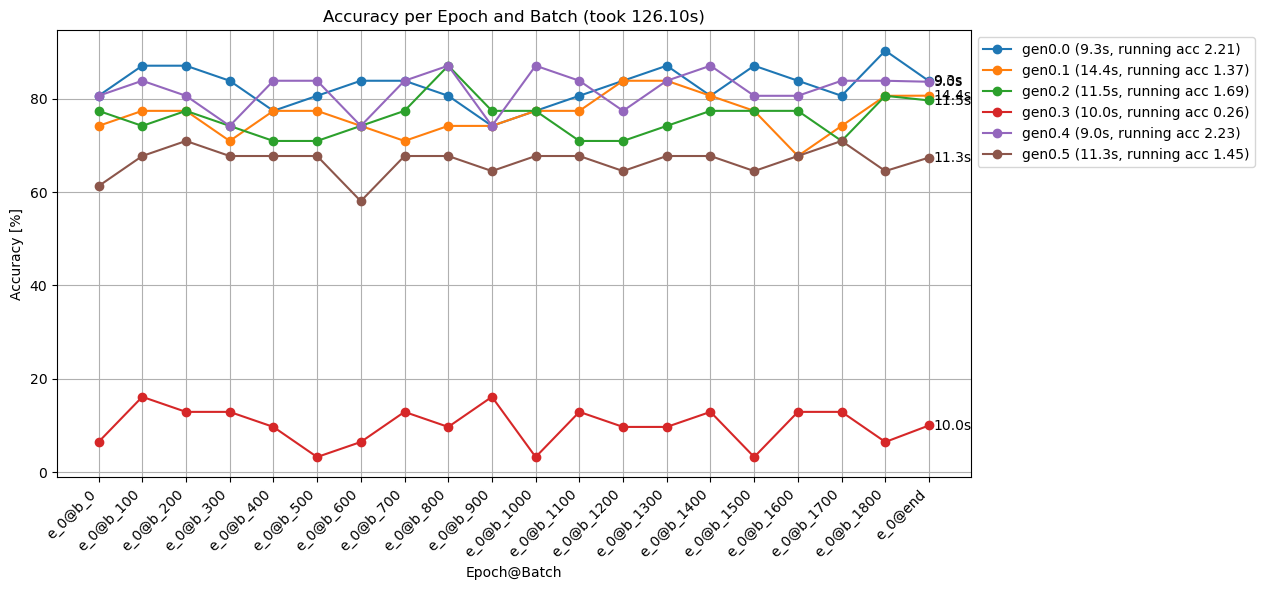

In [507]:
start_time = time.perf_counter() # Start timing
train_and_evaluate_gen(pop, train_dl_f_mnist, test_dl_f_mnist, testing_interval=100, epochs=1, testing_data_fraction=.1)
stop_time = time.perf_counter() # Start timing
pop.plot_accs(elapsed_time=stop_time-start_time)

In [512]:
print(pop[4])

NN_individual(
  (blocks_2d): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lazyLin): Linear(in_features=6272, out_features=10, bias=True)
  (loss_fn): CrossEntropyLoss()
)
